# AllLife Bank Customer Segmentation

## Context

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help


## Objective

To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.


##  Data Description

The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

**Data Dictionary**

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of Visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

## Let's start coding!

### Importing necessary libraries

In [2]:
# this will help in making the Python code more structured automatically (good coding practice)
# %load_ext nb_black

# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist, pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to suppress warnings
import warnings

warnings.filterwarnings("ignore")

In [3]:
# loading the dataset
data = pd.read_excel("CreditCardCustomerData.xlsx", engine='openpyxl')

In [4]:
data.shape

(660, 7)

* The dataset has 660 rows and 7 columns 

In [5]:
# viewing the first 5 rows of the data
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [6]:
# copying the data to another variable to avoid any changes to original data
df = data.copy()

In [7]:
# fixing column names
df.columns = [c.replace(" ", "_") for c in df.columns]

In [8]:
# checking datatypes and number of non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer_Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


- All the columns in the data are numeric.

In [9]:
# checking for missing values
df.isnull().sum()

Sl_No                  0
Customer_Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

- There are no missing values in the data.

In [10]:
# checking the number of unique values in each column
data.nunique()

Sl_No                  660
Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

- There are less unique values in the *Customer_Key* column than the number of observations in the data. This means that there are duplicate values in the column.

**Let's look at the duplicate values in the *Customer_Key* column closely.**

In [10]:
# getting the count for each unique value in Customer_Key
data_grouped = df.groupby("Customer_Key").count()

for i in data_grouped.loc[data_grouped.Sl_No >= 2].index:
    display(data.loc[df.Customer_Key == i])

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
48,49,37252,6000,4,0,2,8
432,433,37252,59000,6,2,1,2


,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
4,5,47437,100000,6,0,12,3
332,333,47437,17000,7,3,1,0


,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
411,412,50706,44000,4,5,0,2
541,542,50706,60000,7,5,2,2


,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
391,392,96929,13000,4,5,0,0
398,399,96929,67000,6,2,2,2


,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
104,105,97935,17000,2,1,2,10
632,633,97935,187000,7,1,7,0


**Observations**

- There are 5 duplicate customer entries in the data.
- Most of these duplicates look like customer profile changes.
- There is no need to delete these records as these are actual occurrences at some point in the time.

**We will drop the *Sl_No* and *Customer_Key* as they do not add any value to the analysis.**

In [11]:
df.drop(columns=["Sl_No"], inplace=True)
df.drop(columns=["Customer_Key"], inplace=True)

In [12]:
# Let's look at the statistical summary of the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


**Observations**

- The average credit limit is heavily right-skewed with a median average credit limit of 18000 dollars.
- The total number of credit cards ranges from 1 to 10 and seems to be evenly distributed with a close values of mean and median.
- *Total_visits_bank* is evenly distributed, but there are some customers who have never visited the bank.
- *Total_Visits_online* seems to be right-skewed and there are some customers who never used the online banking services.
- *Total_calls_made* is right-skewed and there are some customers who never preferred to make any calls to the bank

## EDA

### Univariate analysis

In [13]:
from edafunctions import *

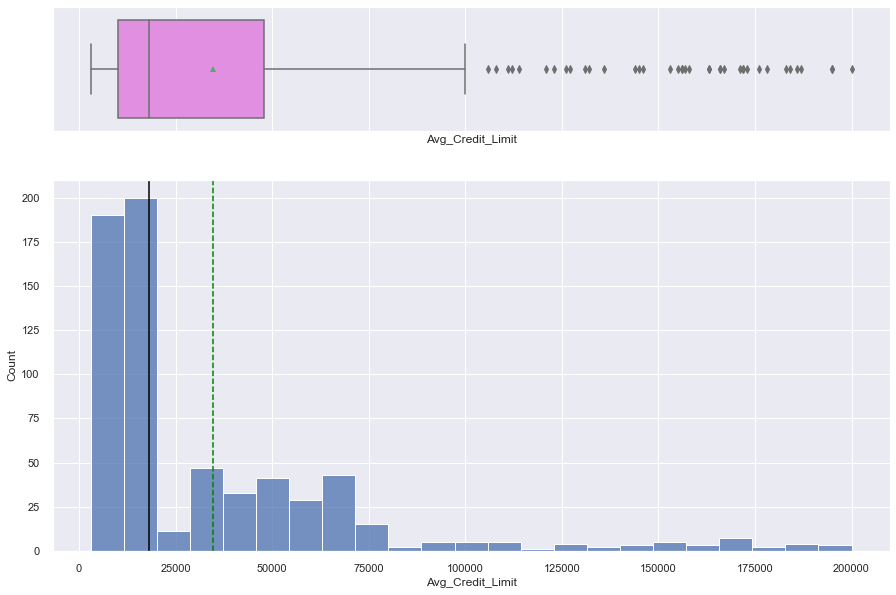

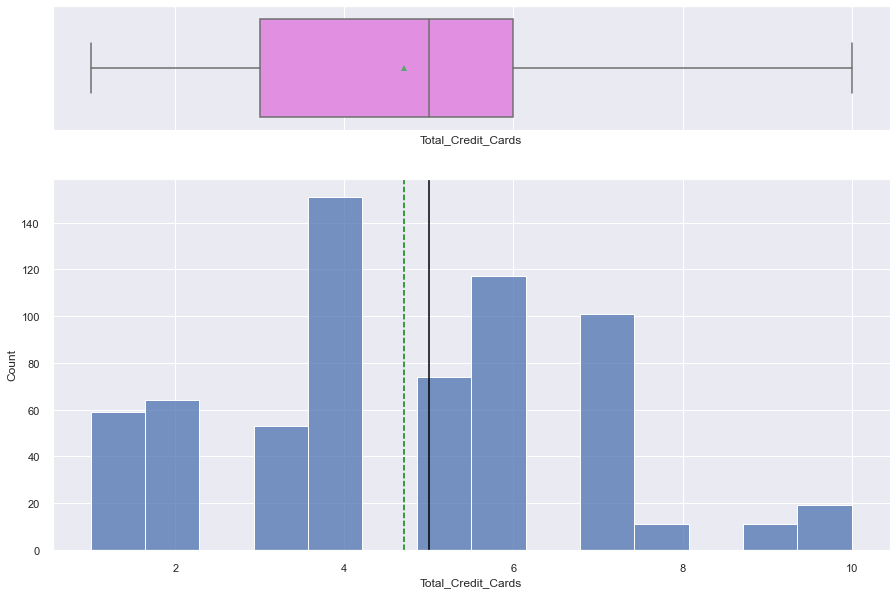

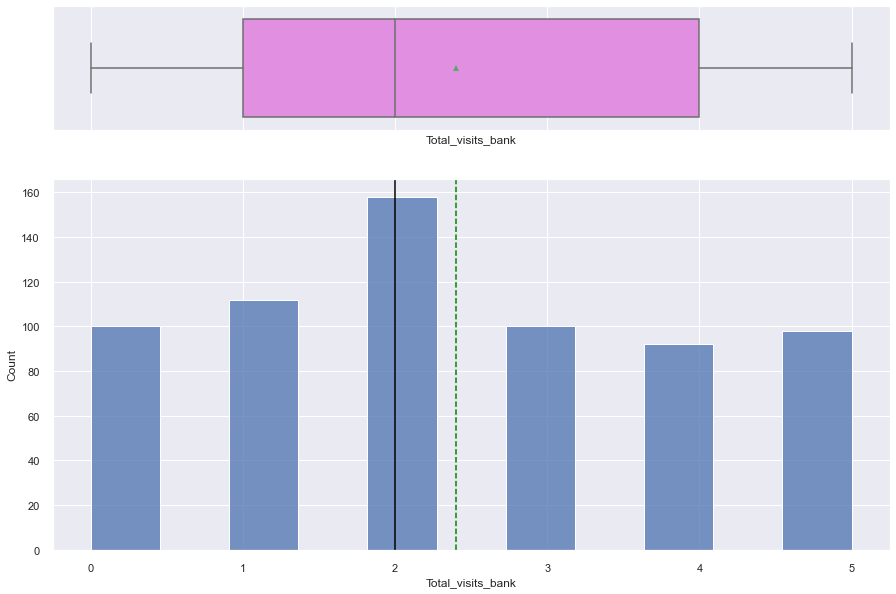

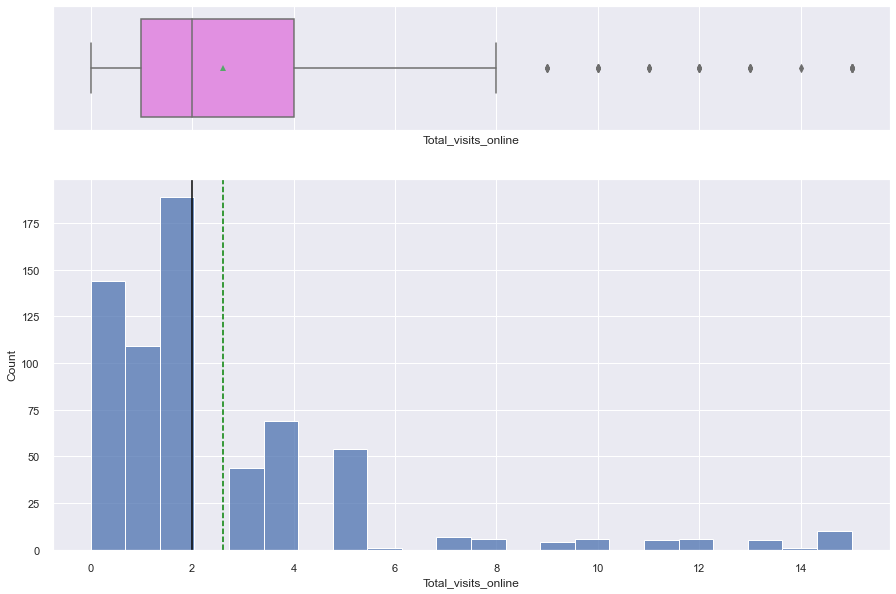

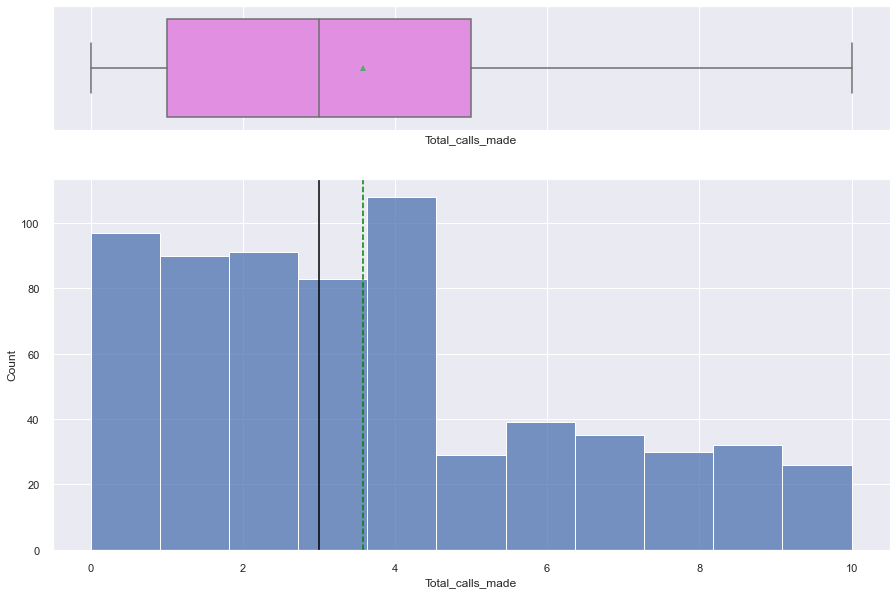

In [15]:
for col in df.columns:
    histogram_boxplot(data, col)

**Observations**

- There are outliers in the *Average_Credit_limit* column, but all the values are continuous, and the gap between the points is evenly distributed.
- In general, customers visit the bank twice a year, log in to the online portal twice a year, and make 3 calls to the customer service.
- We see some outliers in the Total_visits_online column, indicating that few customers log in to the online portal more frequently than the others.

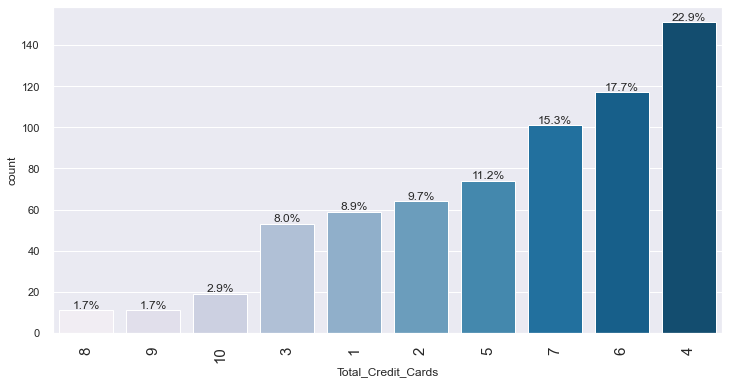

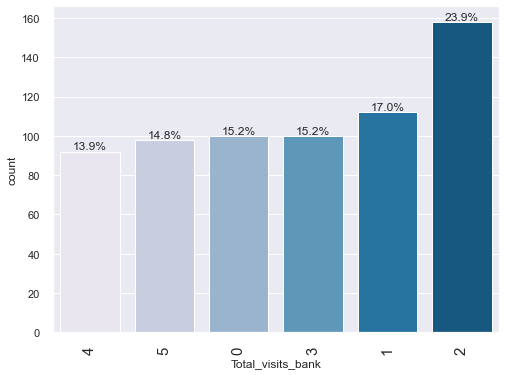

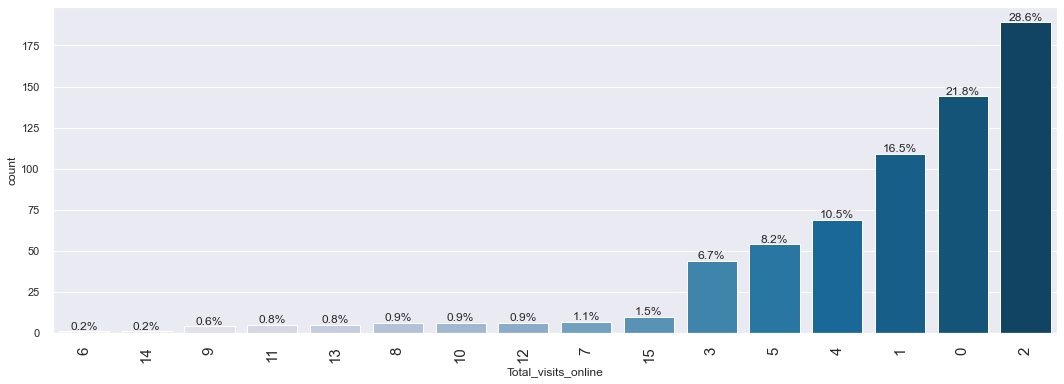

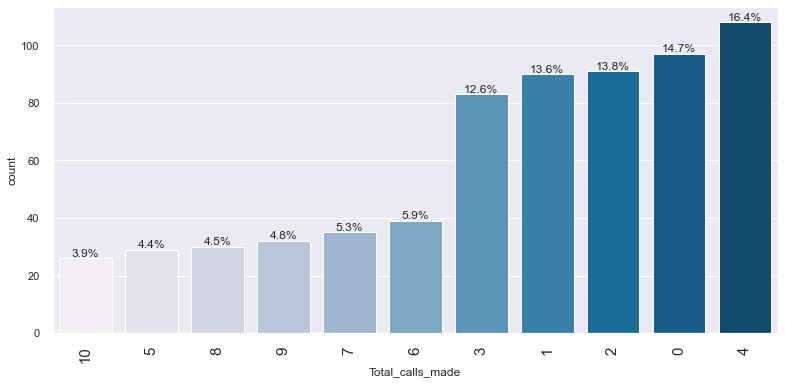

In [20]:
for col in df.columns.tolist()[1:]:
    labeled_barplot(df, col, perc=True)

**Observations**

- Approximately half the customers in the data have 4 or fewer credit cards, and very few customers (approximately 6%) have more than 7 credit cards.
- Approximately 15% of the customers have never visited the bank.
- Approximately 22% of the customers have never logged in to the online portal, while ~7% of the customers used the online banking services more than 6 or more times yearly.
- Approximately 15% of the customers have never made a service-related call to the bank.

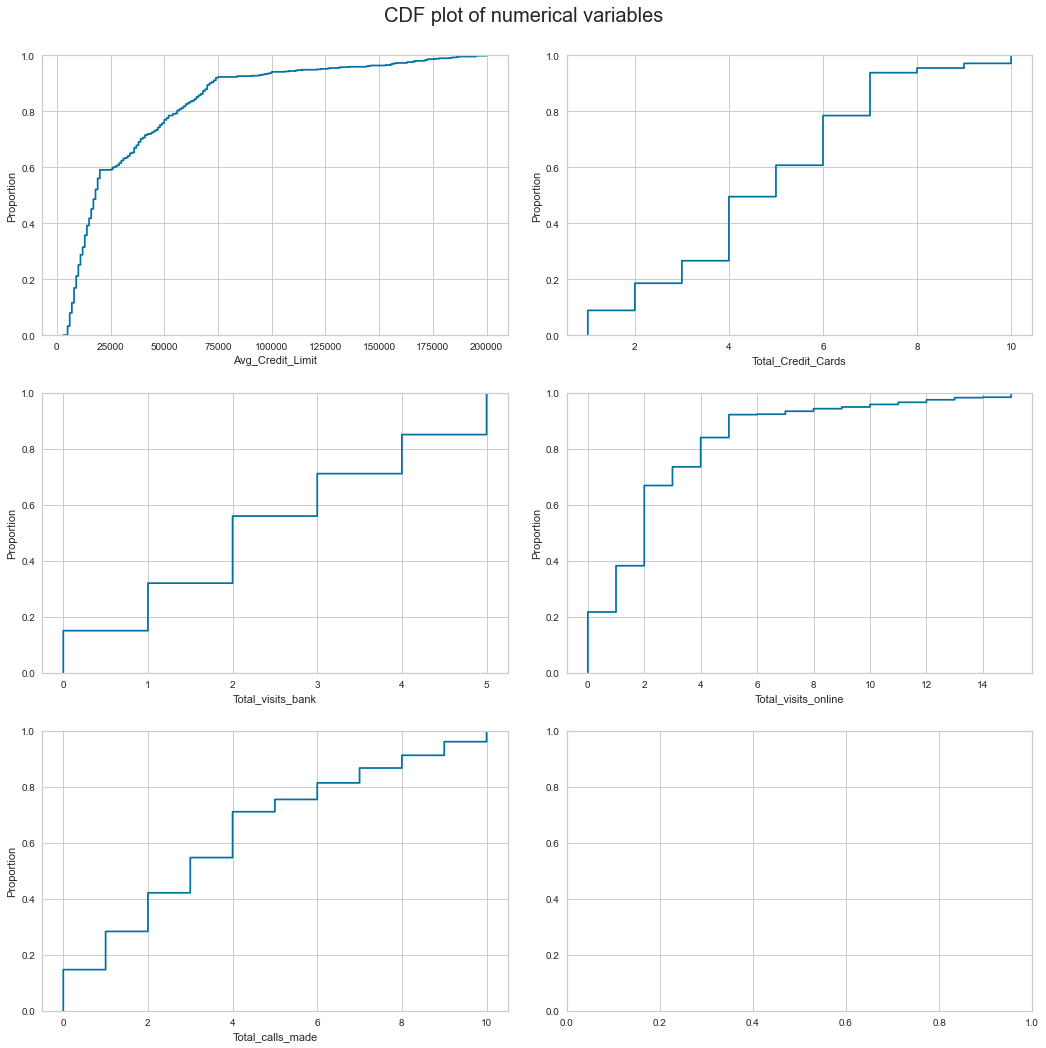

In [10]:
counter = 0
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle("CDF plot of numerical variables", fontsize=20)

"""
An ECDF, empirical cumulative distribution functions represents the proportion or count of observations falling below each unique value in a dataset. Compared to a histogram or density plot, it has the advantage that each observation is visualized directly, meaning that there are no binning or smoothing parameters that need to be adjusted. 
counter = 0
"""

for ii in range(3):
    sns.ecdfplot(data=df, ax=axes[ii][0], x=df.columns.tolist()[counter])
    counter = counter + 1
    if counter != 5:
        sns.ecdfplot(data=df, ax=axes[ii][1], x=df.columns.tolist()[counter])
        counter = counter + 1
    else:
        pass

fig.tight_layout(pad=2.0)

**Observations**

- ~90% of the customers have credit limits of less than 75,000.
- ~90% of the customers have less than 7 credit cards.
- ~85% of the customers visit the bank less than 4 times a year.
- ~90% of the customers visit the online platform 5 times or less a year.
- ~90% of the customers make 8 or fewer calls to the bank a year.

### Bivariate Analysis

**Let's check for correlations.**

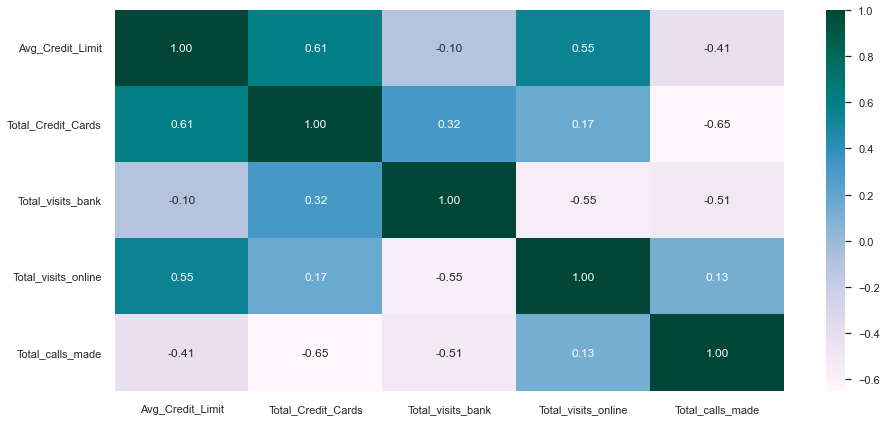

In [22]:
plt.figure(figsize=(15, 7))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="PuBuGn")
plt.show()

**Observations**

- There is a strong negative correlation between *Total_Calls_made* and *Total_credit_cards*.
- There is a strong positive correlation between *Total_credit_cards* and *Avg_credit_limit*, indicating customers with a high average credit limit tend to have more credit cards.

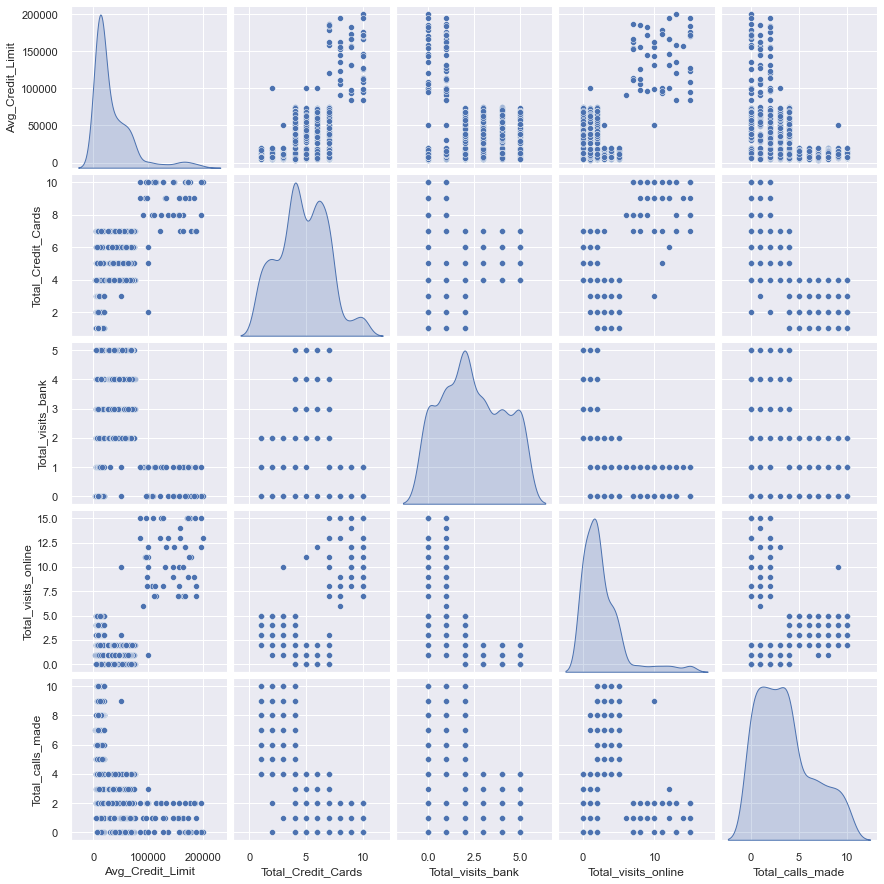

In [23]:
sns.pairplot(data=df, diag_kind="kde")
plt.show()

**Observations**

- There no clear linear correlation between the variables.
- *Total_credit_cards* may have some clusters formed w.r.t other variables.

**We can add a hue and see if we can see some clustered distributions.**

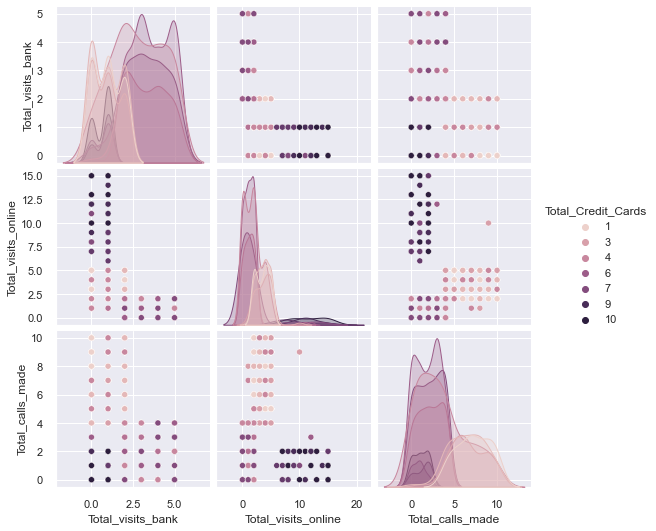

In [24]:
sns.pairplot(
    data=df[
        [
            "Total_visits_bank",
            "Total_visits_online",
            "Total_calls_made",
            "Total_Credit_Cards",
        ]
    ],
    hue="Total_Credit_Cards",
)

plt.show()

**Observations**

- *Total_Credit_Cards* seem to be higher for customers with higher visits online and lesser phone calls made.
- Customers who made more phone calls to the bank seem to have fewer credit cards.

**Let's visualize the modes of contacting the bank in a 3D plot.**

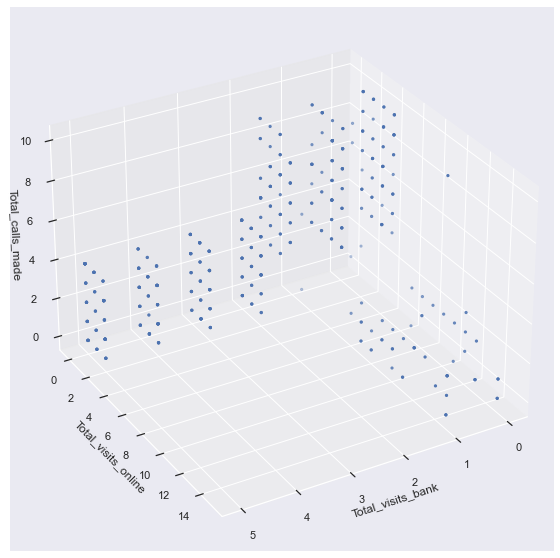

In [25]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")

x = df["Total_visits_bank"]
y = df["Total_visits_online"]
z = df["Total_calls_made"]


ax.scatter(x, y, z, marker=".")
ax.set_xlabel("Total_visits_bank")
ax.set_ylabel("Total_visits_online")
ax.set_zlabel("Total_calls_made")
ax.view_init(azim=60)
plt.show()

- We can observe three segments of the customers by their preferred mode of contacting the bank.

## Data Preprocessing

### Outlier Detection

- Let's find outliers in the data using z-score with a threshold of 3.

In [11]:
threshold = 3
outlier = {}
for col in df.columns:
    i = df[col]
    mean = np.mean(df[col])
    std = np.std(df[col])
    list1 = []
    for v in i:
        z = (v - mean) / std
        if z > threshold:
            list1.append(v)
    list1.sort()
    outlier[i.name] = list1

print("The following are the outliers in the data:")
for key, value in outlier.items():
    print("\n", key, ":", value)

The following are the outliers in the data:

 Avg_Credit_Limit : [153000, 155000, 156000, 156000, 157000, 158000, 163000, 163000, 166000, 166000, 167000, 171000, 172000, 172000, 173000, 176000, 178000, 183000, 184000, 186000, 187000, 195000, 195000, 200000]

 Total_Credit_Cards : []

 Total_visits_bank : []

 Total_visits_online : [12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]

 Total_calls_made : []


**Observations**

- There are outliers in the columns *Avg_Credit_Limit* and *Total_Visits_online*.
- We will not treat the outliers as most of those outliers are not disjoint from the curve (continues curve).
- These outliers might also form their own cluster.

### Scaling

- Let's scale the data before we proceed with clustering.

In [14]:
# scaling the data before clustering
scaler = StandardScaler()
subset = df.copy()
subset_scaled = scaler.fit_transform(subset)

In [15]:
# creating a dataframe of the scaled data
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

## K-Medians and K-Medoids Clustering

<img src="https://raw.githubusercontent.com/maisonml/mlflashcards/master/kMedianskMedoids.jpg" width=500 height=700 />


## K-means Clustering

In [16]:
k_means_df = subset_scaled_df.copy()



## WCSS/ Intertia and Mean Distortion

<img src="https://raw.githubusercontent.com/maisonml/mlflashcards/master/WCSS_Distortion.jpg" width=500 height=700 />

Number of Clusters: 1 	Average Distortion: 5.0000000000000036 	Inertia: 3300.0000000000023
Number of Clusters: 2 	Average Distortion: 3.092408812846204 	Inertia: 2040.9898164784947
Number of Clusters: 3 	Average Distortion: 1.4137026500000804 	Inertia: 933.0437490000533
Number of Clusters: 4 	Average Distortion: 1.1829904387199652 	Inertia: 780.7736895551769
Number of Clusters: 5 	Average Distortion: 1.067387755857199 	Inertia: 704.4759188657516
Number of Clusters: 6 	Average Distortion: 0.9733765835489714 	Inertia: 642.428545142321
Number of Clusters: 7 	Average Distortion: 0.909430117935752 	Inertia: 600.2238778375963
Number of Clusters: 8 	Average Distortion: 0.8703665088147914 	Inertia: 574.4418958177623


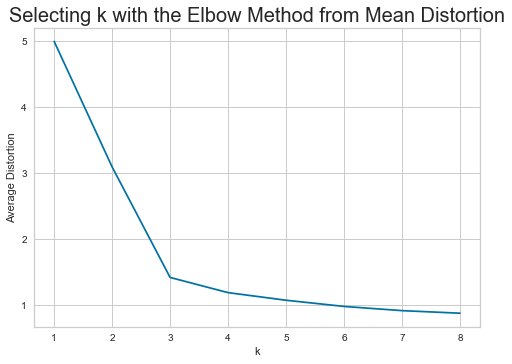

In [17]:
clusters = range(1, 9)
meanDistortions = []
inertialist = []

for k in clusters:
    model = KMeans(n_clusters=k, random_state=1)
    model.fit(subset_scaled_df)
    prediction = model.predict(k_means_df)
    distortion = (
        sum(np.square(np.min(cdist(k_means_df, model.cluster_centers_, "euclidean"), axis=1)))
        / k_means_df.shape[0]
    ) # Distortion is the average of the euclidean squared distance from the centroid of the respective clusters.
    inertia = model.inertia_ # WCSS/ Inertia is the sum of squared distances of samples to their closest cluster centre
    meanDistortions.append(distortion)
    inertialist.append(inertialist)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion, "\tInertia:", inertia)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method from Mean Distortion", fontsize=20)
plt.show()


**The appropriate value of k from the Elbow curve seems to be 2 or 3.**

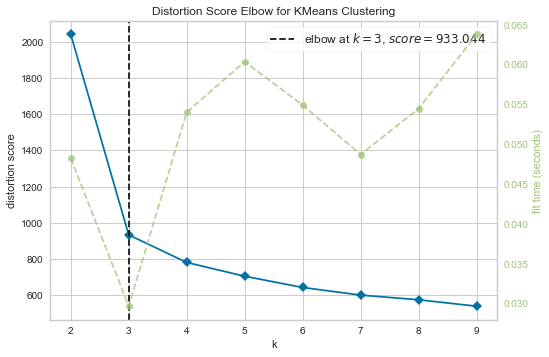

In [17]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2, 10), timings=True)
visualizer.fit(k_means_df)  # fit the data to the visualizer
visualizer.show();  # finalize and render figure

**Let's check the silhouette scores.**

## Silhouette Coefficient

<img src="https://raw.githubusercontent.com/maisonml/mlflashcards/master/SilouhetteCoeff.jpg" width=500 height=700 />

In [18]:
sil_score = []
cluster_list = range(2, 10)
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    preds = clusterer.fit_predict((subset_scaled_df))
    score = silhouette_score(k_means_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, the silhouette score is 0.41842496663215445)
For n_clusters = 3, the silhouette score is 0.5157182558881063)
For n_clusters = 4, the silhouette score is 0.3556670619372605)
For n_clusters = 5, the silhouette score is 0.2717470361089752)
For n_clusters = 6, the silhouette score is 0.255906765297388)
For n_clusters = 7, the silhouette score is 0.24798644656011146)
For n_clusters = 8, the silhouette score is 0.2414240144760896)
For n_clusters = 9, the silhouette score is 0.2184645050755029)


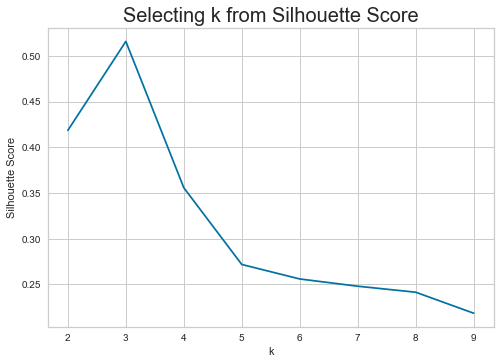

In [36]:
plt.plot(cluster_list, sil_score)
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Selecting k from Silhouette Score", fontsize=20)
plt.show()

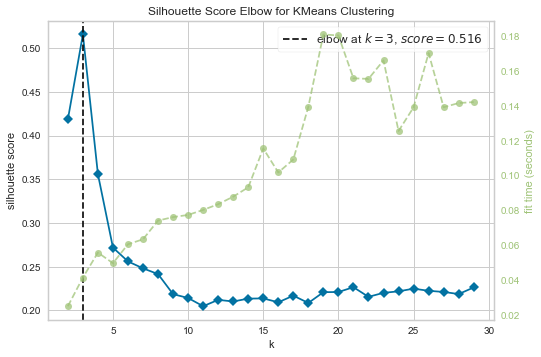

In [21]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2, 30), metric="silhouette", timings=True)
visualizer.fit(k_means_df)  # fit the data to the visualizer
visualizer.show();  # finalize and render figure

**From the silhouette scores, it seems that 3 is a good value for k.**

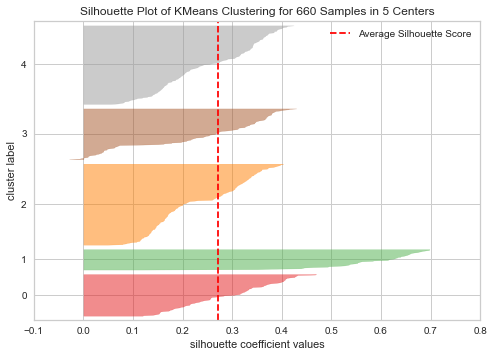

In [24]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(k_means_df)
visualizer.show();

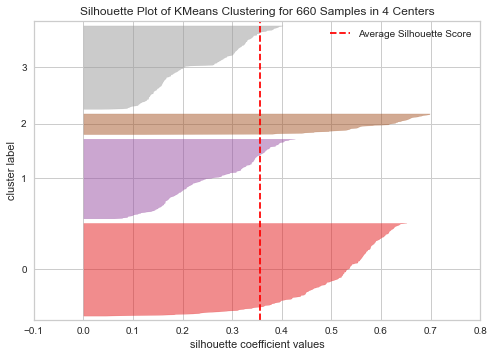

In [25]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(k_means_df)
visualizer.show();

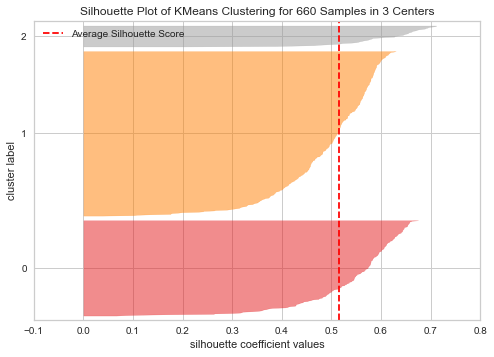

In [26]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(k_means_df)
visualizer.show();

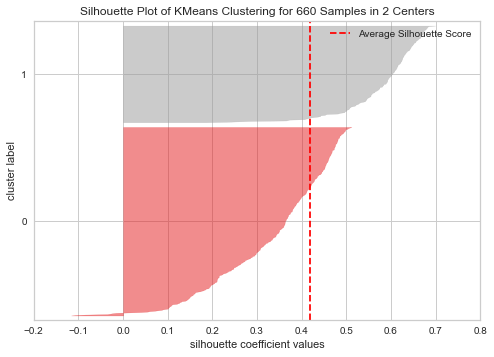

In [27]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(2, random_state=1))
visualizer.fit(k_means_df)
visualizer.show();

**Observations**

- The silhouette coefficient for 3 clusters is the highest.
- We can also see that the score for 3 clusters is close to the average score and the shape of the clusters is very uniform in SilhouetteVisualizer, even though the magnitude may be different.
- So, we will proceed with 3 clusters.

In [19]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(k_means_df)

KMeans(n_clusters=3, random_state=0)

In [20]:
# creating a copy of the original data
df1 = df.copy()

# adding kmeans cluster labels to the original and scaled dataframes
k_means_df["K_means_segments"] = kmeans.labels_
df1["K_means_segments"] = kmeans.labels_

## Hierarchical Clustering

In [21]:
hc_df = subset_scaled_df.copy()

## Cophonetic Correlation
<img src="https://raw.githubusercontent.com/maisonml/mlflashcards/master/CophoneticCorrelation.jpg" width=500 height=700 />

In [22]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(hc_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(hc_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553605.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6663534463875359.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8326994115042136.
Cophenetic co

In [32]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with Euclidean distance and average linkage.


**Let's explore different linkage methods with Euclidean distance only.**

In [23]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# The WPGMA algorithm constructs a rooted tree (dendrogram) that reflects the structure present in a 
# pairwise distance matrix (or a similarity matrix). At each step, the nearest two clusters, say 
# i and j, are combined into a higher-level cluster i UNION j. 
# Then, its distance to another cluster k is simply the arithmetic mean of the average distances 
# between members of k and i and k and j

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(hc_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(hc_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.7391220243806552.
Cophenetic correlation for complete linkage is 0.8599730607972423.
Cophenetic correlation for average linkage is 0.8977080867389372.
Cophenetic correlation for centroid linkage is 0.8939385846326323.
Cophenetic correlation for ward linkage is 0.7415156284827493.
Cophenetic correlation for weighted linkage is 0.8861746814895477.


In [34]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print()
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)


Highest cophenetic correlation is 0.8977080867389372, which is obtained with average linkage.


**We see that the cophenetic correlation is maximum with Euclidean distance and average linkage.**


**Let's view the dendrograms for the different linkage methods.**

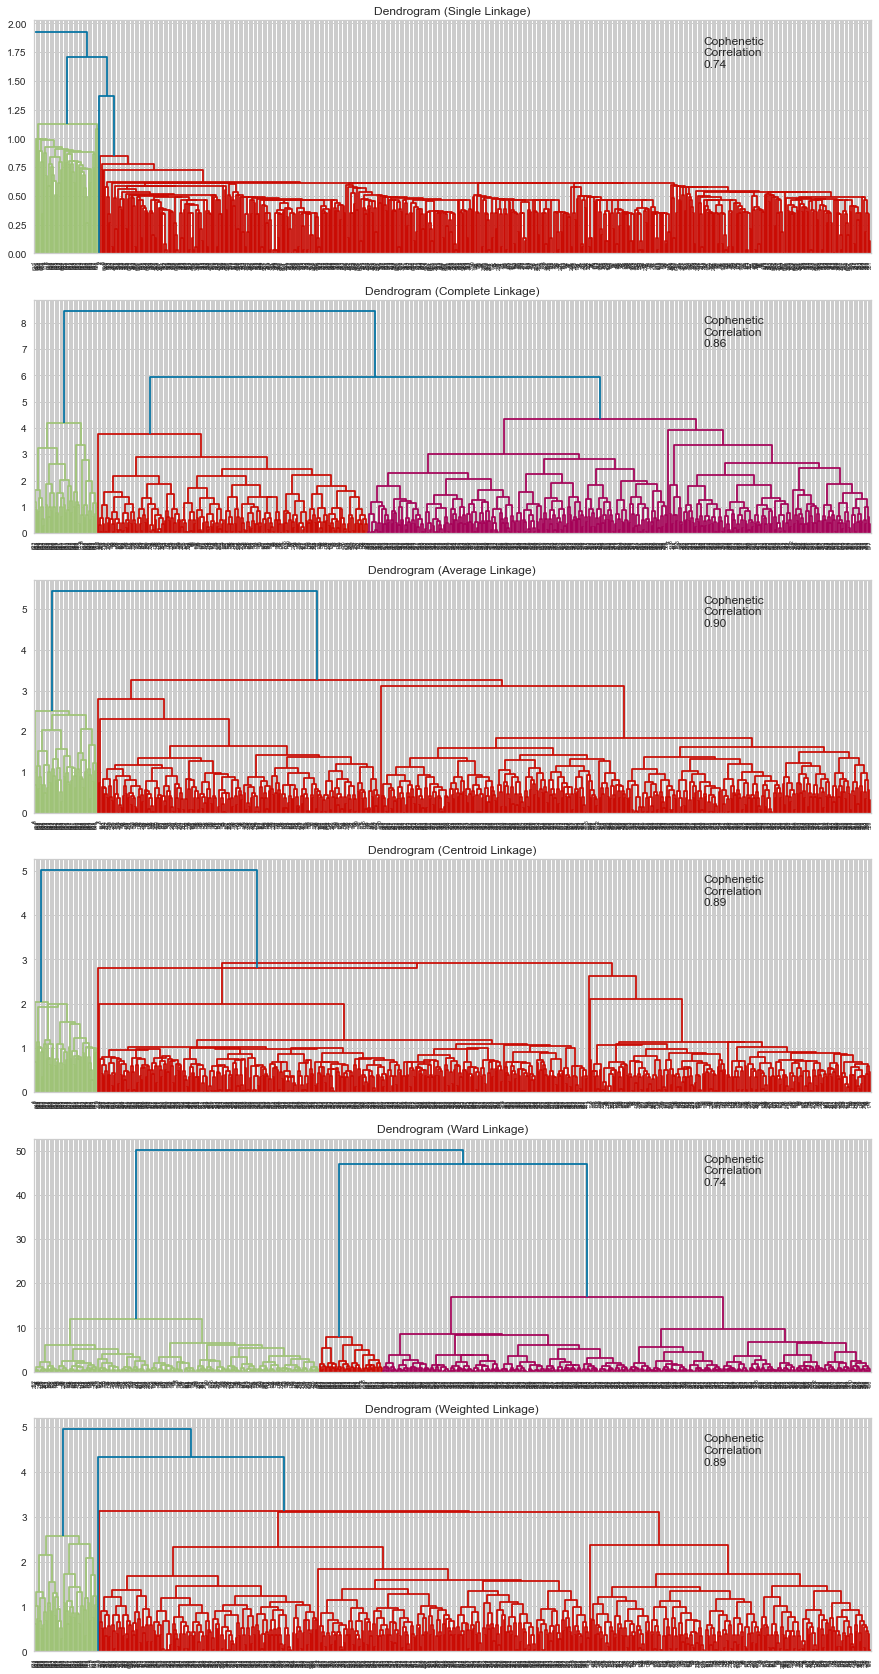

In [35]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(hc_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(hc_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

**Dendrogram with average linkage shows distinct and separate cluster tree.**

In [43]:
# create and print a dataframe to compare cophenetic correlations for different linkage methods
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc = df_cc.sort_values(by="Cophenetic Coefficient")
df_cc

,Linkage,Cophenetic Coefficient
0,single,0.739122
4,ward,0.741516
1,complete,0.859973
5,weighted,0.886175
3,centroid,0.893939
2,average,0.897708


<IPython.core.display.Javascript object>

**Let's move ahead with 3 clusters, Euclidean distance, and average linkage.**

In [24]:
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
HCmodel.fit(hc_df)

AgglomerativeClustering(linkage='average', n_clusters=3)

In [25]:
# creating a copy of the original data
df2 = df.copy()

# adding hierarchical cluster labels to the original and scaled dataframes
hc_df["HC_segments"] = HCmodel.labels_
df2["HC_segments"] = HCmodel.labels_

In [26]:
hc_df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,HC_segments
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537,0
1,0.410293,-0.787585,-1.473731,2.520519,1.891859,2
2,0.410293,1.058973,-0.860451,0.134290,0.145528,0
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528,0
4,1.740187,0.597334,-1.473731,3.202298,-0.203739,1


In [27]:
df2.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,HC_segments
0,100000,2,1,1,0,0
1,50000,3,0,10,9,2
2,50000,7,1,3,4,0
3,30000,5,1,1,4,0
4,100000,6,0,12,3,1


In [28]:
subset_scaled_df["HC_Clusters"] = HCmodel.labels_
df["HC_Clusters"] = HCmodel.labels_

## Cluster Profiling and Comparison

### Cluster Profiling: K-means Clustering

In [29]:
km_cluster_profile = df1.groupby("K_means_segments").mean()

In [30]:
km_cluster_profile["count_in_each_segment"] = (
    df1.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

In [31]:
km_cluster_profile

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


### Cluster Profiling: Hierarchical Clustering

In [32]:
hc_cluster_profile = df2.groupby("HC_segments").mean()

In [33]:
hc_cluster_profile["count_in_each_segment"] = (
    df2.groupby("HC_segments")["Avg_Credit_Limit"].count().values
)

In [34]:
hc_cluster_profile

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
HC_segments,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,387
1,141040.000000,8.740000,0.600000,10.900000,1.080000,50
2,12197.309417,2.403587,0.928251,3.560538,6.883408,223


### K-Means Clustering vs Hierarchical Clustering Comparison

In [35]:
km_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


In [36]:
hc_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
HC_segments,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,387
1,141040.000000,8.740000,0.600000,10.900000,1.080000,50
2,12197.309417,2.403587,0.928251,3.560538,6.883408,223


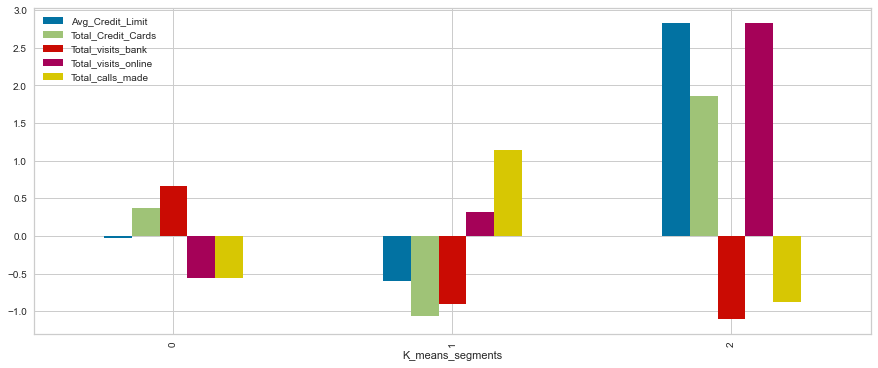

In [37]:
k_means_df.groupby("K_means_segments").mean().plot.bar(figsize=(15, 6));

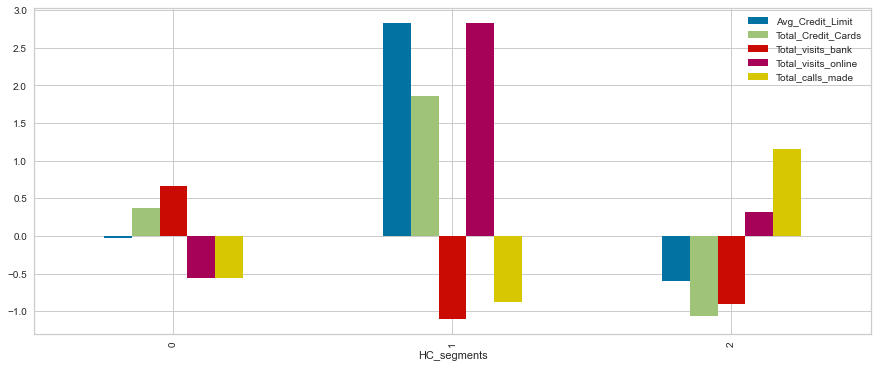

In [38]:
hc_df.groupby("HC_segments").mean().plot.bar(figsize=(15, 6));

**Looks like the K-Means and Hierarchical clusters are the same except that the labels are swapped between clusters 1 and 2.**


**Let's swap the labels for K-Means for better analysis and comparison.**

In [39]:
k_means_df.loc[k_means_df["K_means_segments"] == 1, "K_means_segments"] = 3
k_means_df.loc[k_means_df["K_means_segments"] == 2, "K_means_segments"] = 1
k_means_df.loc[k_means_df["K_means_segments"] == 3, "K_means_segments"] = 2
df1["K_means_segments"] = k_means_df["K_means_segments"]

km_cluster_profile = df1.groupby("K_means_segments").mean()
km_cluster_profile["count_in_each_segment"] = (
    df1.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

In [40]:
km_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,141040.000000,8.740000,0.600000,10.900000,1.080000,50
2,12174.107143,2.410714,0.933036,3.553571,6.870536,224


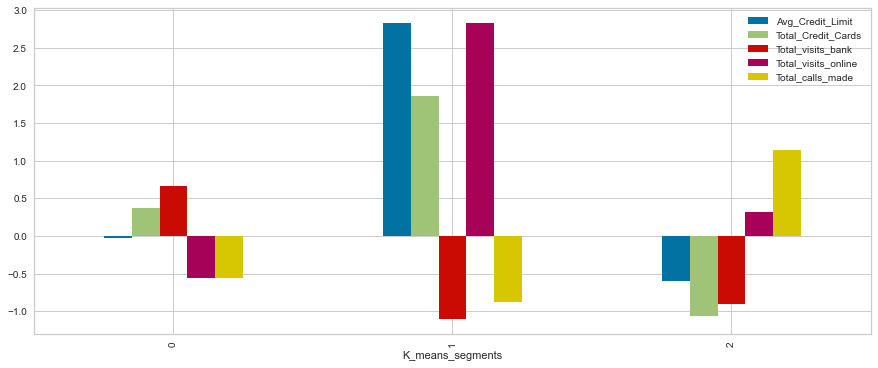

In [41]:
k_means_df.groupby("K_means_segments").mean().plot.bar(figsize=(15, 6));

**Observations**

- The online user segment matches for both K-means and Hierarchical Clustering techniques.
- There is a clear distinction between customers who prefer online banking vs others.
- Online users have more credit cards and a larger credit limit, which is beneficial for the bank with respect to the revenue and cutting the costs of manual engagement with the customers.

**Let's create some plots on the original data to understand the customer distribution among the clusters.**

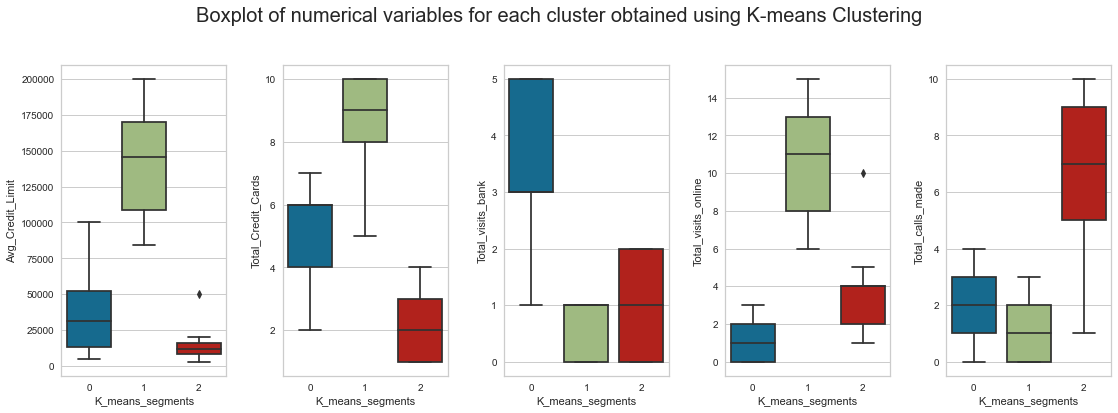

In [42]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle(
    "Boxplot of numerical variables for each cluster obtained using K-means Clustering",
    fontsize=20,
)

counter = 0

for ii in range(5):
    sns.boxplot(
        ax=axes[ii], y=df1[df1.columns[counter]], x=k_means_df["K_means_segments"]
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

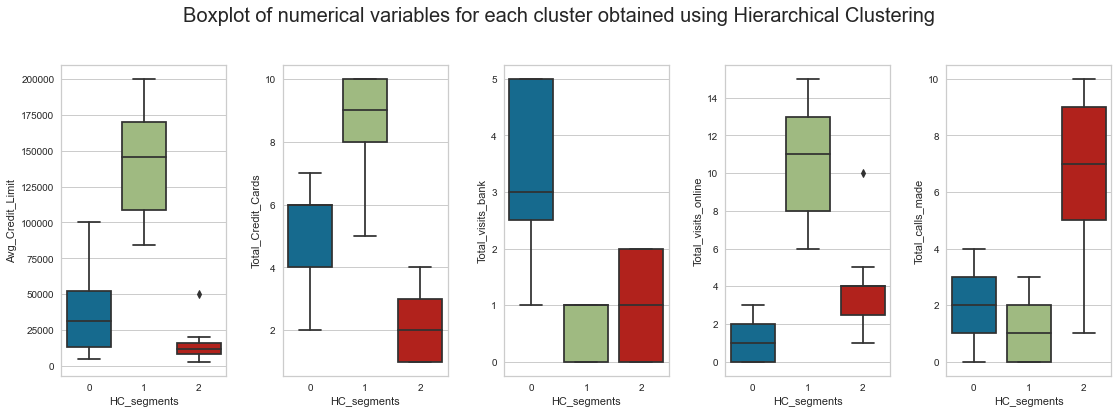

In [43]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle(
    "Boxplot of numerical variables for each cluster obtained using Hierarchical Clustering",
    fontsize=20,
)

counter = 0

for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df2[df2.columns[counter]], x=hc_df["HC_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

### Cluster Comparison

**Cluster 0:**

- Close to 60% of the customers are in this group.
- This cluster has the second-highest credit limit and number of credit cards.
- Customers in this group prefer to visit the bank for their banking needs than doing business online or over the phone. Total visits to be bank are ranging between 1 and 5, but most of them are skewed to the left.
- There is almost equal distribution of phone bankers and online bankers in this cluster. Some of the customers have never visited online, while the highest number of online visits is 3. Some customers have never made any phone banking
- This may be the bank's second-best cluster as there are more cards and credit limits than cluster 1.


**Cluster 1:**

- There are very few customers in this segment (only around 7%).
- This cluster seems to be a premium cluster with the highest average credit limit and the highest number of credit cards.
- Average credit limit for this group is between 85000 and 200000 dollars, with an average of ~141000 dollars.
- Total credit cards are between 5 and 10 with a tail on the left, but most customers are within the 8 to 10 range.
- Customers in this group prefer online banking, with an even distribution of 6 to 15 visits.
- Customers in this group have the lowest phone calls made and visits to the bank, with some customers never making any phone calls and some never visiting the bank.


**Cluster 2:**

- Around 1/3rd of the customers are in this cluster.
- This cluster has the lowest number of credit cards, ranging from 1 to 4.
- This cluster has the lowest average credit limit and most of them are below 2500 dollars with an outlier of around 5000 dollars.
- The total number of calls made by this segment of customers is the highest among all the clusters and ranges between 1 and 10.
- Customers in this segment have the lowest online visits, ranging from 1 to 5 with an outlier of 10 visits.

## Insights

- We have seen that 3 clusters are distinctly formed using both methodologies and the clusters are analogous to each other.
- Cluster 1 has premium customers with a high credit limit and more credit cards, indicating that they have more purchasing power. The customers in this group have a preference for online banking.
- Cluster 0 has customers who prefer to visit the bank for their banking needs than doing business online or over the phone. They have an average credit limit and a moderate number of credit cards.
- Cluster 2 has more overhead of customers calling in, and the bank may need to spend money on call centers.


## Business Recommendations

- The premium customers of Cluster 1 have the potential to add more revenue to the bank, and the bank should run incentives to draw more customers of this kind. The bank can also run promotions and offer discounts for paperless billing and online banking to drive more customers into this group.
- Cluster 0 has customers who prefer to visit the bank for their banking needs than doing business online or over the phone. They have an average credit limit and number of credit cards. The bank can increase their revenue by focusing on the volume of customers in Cluster 0.
- Since the Cluster 2 customers prefer to use phone banking, the bank can invest in automating the phone banking so that the overhead can be reduced. Phone banking can also be expanded to chat applications like WhatsApp and Telegram.
- Bank should invest in making online banking more easier and secure. It should also run a campaign on the security and convenience feature of online banking.

## Add-on: Cluster Overlapping

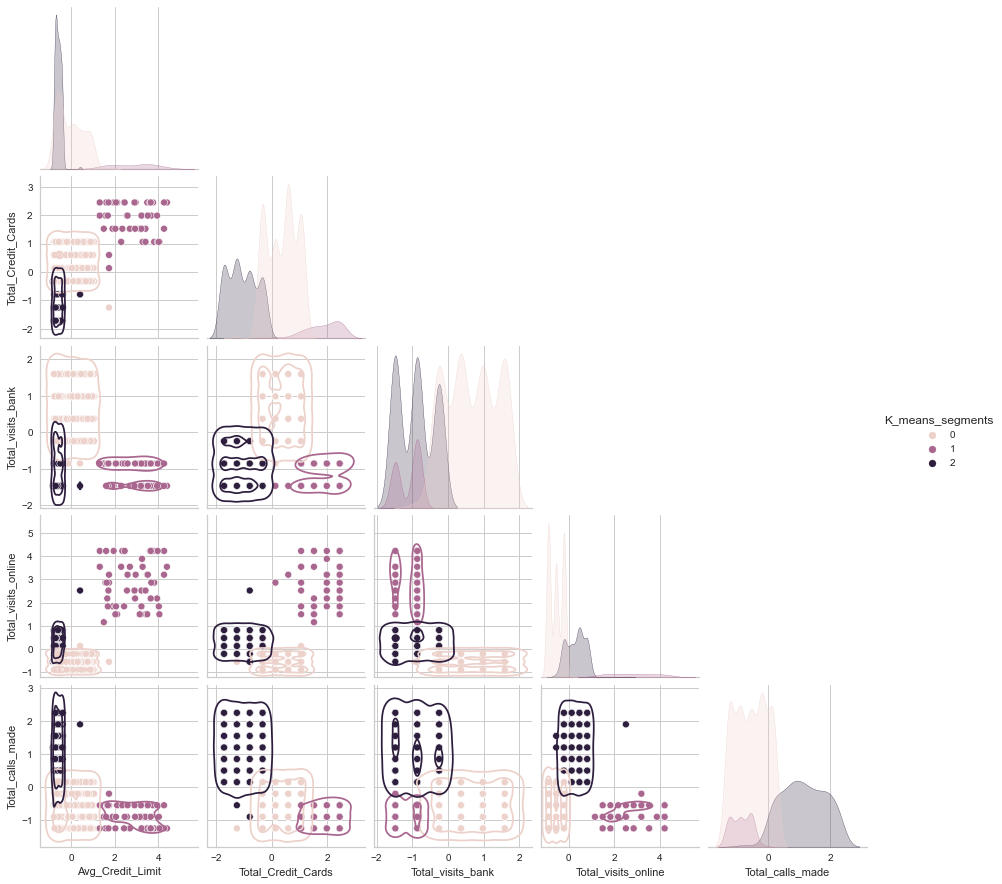

In [44]:
# let's see if there is any overlap in the clusters
g = sns.pairplot(
    k_means_df[
        [
            "Avg_Credit_Limit",
            "Total_Credit_Cards",
            "Total_visits_bank",
            "Total_visits_online",
            "Total_calls_made",
            "K_means_segments",
        ]
    ],
    diag_kind="kde",
    corner=True,
    hue="K_means_segments",
)
g.map_lower(sns.kdeplot, levels=3, color=".2")
plt.show()

**Observations**

- We can see that Cluster 1 is more clearly separated compared to Cluster 0 and Cluster 2 and that there is an overlap between Cluster 0 and Cluster 2.
- Cluster 2 has some customers whose behavior is a little different from the rest of the group.
- We can see that in Cluster 2 when the average credit limit and the number of credit cards is low, total calls made are high, and this is the opposite in the case of Cluster 1.
- We can see a clear correlation between a higher average credit limit and more number of cards in Cluster 1.

## Add-on: PCA for visualization

- Let's use PCA to reduce the data to two dimensions and visualize it to see how well-separated the clusters are.

In [45]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_reduced_pca = pca.fit_transform(subset_scaled_df)

# storing results in a dataframe
reduced_data_df_pca = pd.DataFrame(
    data=X_reduced_pca, columns=["Component 1", "Component 2"]
)

# checking the amount of variance explained
print(
    f"The first two principal components explain {np.round(100*pca.explained_variance_ratio_.sum(), 2)}% of the variance in the data."
)

The first two principal components explain 84.02% of the variance in the data.


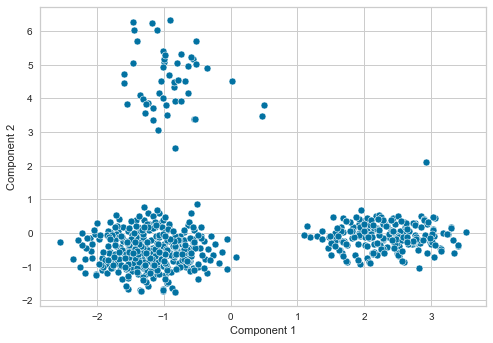

In [46]:
sns.scatterplot(data=reduced_data_df_pca, x="Component 1", y="Component 2");

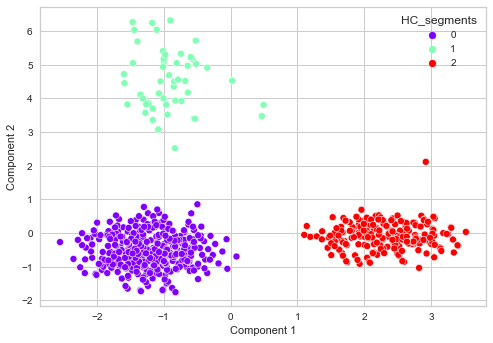

In [47]:
sns.scatterplot(
    data=reduced_data_df_pca,
    x="Component 1",
    y="Component 2",
    hue=df2["HC_segments"],
    palette="rainbow",
);

- The clusters are clearly well separated.